# Non-linear inverse problem: Earthquake location

T.-S. Pham
August 2025

As part of the 2025 PHYS3070 Physics of the Earth's Seismology.

Earthquake location is a classic problem in seismology. Here we consider a synthetic problem to locate a seismic source in a homogenous, acoustic media. The setup includes:
- A seismic source is located at 10 km depth, triggered at the origin time, $t=0$.
- 10 receivers randomly located on the free surface $(x_i, y_i, 0)$, where $i = 1, ..., 10$.
- Energy from the source propagates at a homogenous speed $v= 5 km/s$ in the media.

Given ${d_i, i=1, ..., 10}$ being the travel arrival times observed at the receivers. What are the location and time of the source?

In [85]:
import numpy as np

# true earthquake location
m_true = np.array([0, 0, 10, 0])
v = 5

# station locations
np.random.seed(2)
nr = 10
rcvs = np.zeros((nr, 3)) # receiver coordinates
rcvs[:, :2] = np.random.uniform(-300, 300, (nr, 2)) # randomised x, y, z=0

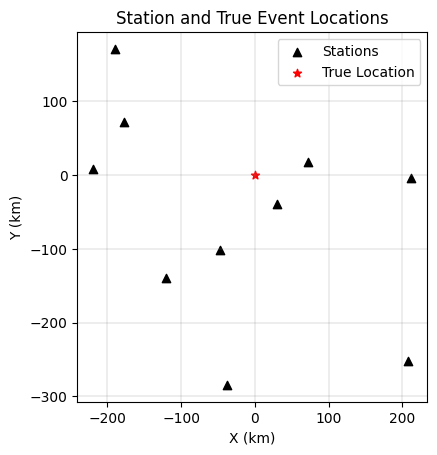

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(rcvs[:, 0], rcvs[:, 1], marker='^', color='k', label='Stations')
ax.scatter(m_true[0], m_true[1], marker='*', color='r', label='True Location')
ax.set(xlabel='X (km)', ylabel='Y (km)', title='Station and True Event Locations')
ax.set(aspect='equal', adjustable='box')
ax.grid(lw=.2, color='gray')
plt.legend()
plt.show()

--- 
## Forward problem

In a homogenous media, seismic wave propagate along a straight rays, just the forward problem derterming the arrival times to each station is defined as,
$$
\hat{d}_i = \frac{\sqrt{(x_i - x_s)^2 + (y_i - y_s)^2 + z_s^2}}{v} + t,
$$
where $(x_s, y_s, z_s)$ are coordinates of the seismic sources. Note that the forward problem can not be represented directly in the linear form of the unknown parameters.
$$
d_i = \hat{d}_i + \mathcal{N}(0, \sigma).
$$

In [87]:
def forward_prob(m): return np.linalg.norm(rcvs - m[0:3], axis=1) / v + m[3]

sigma = 0.1
data = forward_prob(m_true) + np.random.normal(0, sigma, size=nr) # add noise

---
## Gridsearh method

Bruteforce gridsearch is use rather often in solving non-linear inverse problems in seismology due to its simplification setup and great visualization impression. 

The algorithm search for the best fit to the data over a dense mesh surronding a initial guess of the solution. 

---
## Linearized iteration

$$\mathbf{m} = (x, y, z, t)$$

$$
G_{ij} = \frac{\partial d_i}{\partial m_j}|_{\mathbf{m}^1}
$$

$$
\Delta \mathbf{d}^1 = G \Delta \mathbf{m}^1
$$

$$
d_i = T(\mathbf{x}, \mathbf{x}_i) + t = \frac{1}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{1/2} + t.
$$

$$
G_{i1} = \frac{\partial d_i}{\partial m_1} = \frac{\partial d_i}{\partial x} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{(x-x_i)}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2}
$$

$$
G_{i2} = \frac{\partial d_i}{\partial m_2} = \frac{\partial d_i}{\partial y} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{(y-y_i)}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2}
$$

$$
G_{i3} = \frac{\partial d_i}{\partial m_3} = \frac{\partial d_i}{\partial z} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{z}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2}
$$

$$
G_{i4} = \frac{\partial d_i}{\partial m_2} = \frac{\partial d_i}{\partial t} = 1.
$$

In [88]:
def jacobian_mat(m):
    dist = np.linalg.norm(rcvs - m[0:3], axis=1)
    G = -np.ones((nr, 4))
    G[:, :3] = np.einsum('ij,i->ij', rcvs - m[0:3], 1 / (v * dist))
    return G

m0 = np.array([3, 4, 20, 2])
print ('m0:', m0)

G0 = jacobian_mat(m0)
delta_d = data - forward_prob(m0)
delta_m = np.linalg.pinv(G0) @ delta_d
m1 = m0 - delta_m
print ('m1:', m1)

G1 = jacobian_mat(m1)
delta_d = data - forward_prob(m1)
delta_m = np.linalg.pinv(G1) @ delta_d
m2 = m1 - delta_m
print ('m2:', m2)

G2 = jacobian_mat(m2)
delta_d = data - forward_prob(m2)
delta_m = np.linalg.pinv(G2) @ delta_d
m3 = m2 - delta_m
print ('m3:', m3)

print ('--------------')
print ('mt:', m_true)

m0: [ 3  4 20  2]
m1: [ 0.17080348 -0.09526355 13.63544478 -0.07129062]
m2: [ 0.20345501 -0.03453947 11.94184539 -0.078673  ]
m3: [ 0.20353343 -0.03433373 11.83406707 -0.07884537]
--------------
mt: [ 0  0 10  0]


---
## Bayesian inference

### Prior probability

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds
$$
\begin{align*}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= 0, \quad {\rm otherwise},
\end{align*}
$$
where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

It is convient to work with log probability in Bayesian sampling and assume $V=1$ as it's a constant,
$$
\begin{align*}
\log p({\mathbf m}) &= 0,\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= -\infty, \quad {\rm otherwise},
\end{align*}
$$

Here use the uniform distribution with ${\mathbf l}^T = (-20.,-20.,-20.,-20.)$, and ${\mathbf u}^T = (20.,20.,20.,20.)$.

In [ ]:
nparams = len(m_true)
m_lower_bound = np.array([-10, -10, 0, -10])  # lower bound for uniform prior
m_upper_bound = np.array([10, 10, 20, 10])    # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

### Likelihood

Since data errors follow a Gaussian in this example, we can define a likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$.

$$
p({\mathbf d}_{obs} | {\mathbf m}) = \dfrac{1}{\sqrt{(2\pi)^N\det(C_D)}} \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.

To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$. For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ and $\det(C_D) = \sigma^{2N}$ and the likelihood function becomes
$$
p({\mathbf d}_{obs} | {\mathbf m}) = (2\pi \sigma^2)^{-\dfrac{N}{2}} \exp \left\{- \frac{1}{2} \sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2\right\}.
$$

For convenience, the log probability is often used to simplify the calculation and avoid floating over/underflow errors,
$$
\log p({\mathbf d}_{obs} | {\mathbf m}) = - \frac{1}{2}\left(N \log (2\pi\sigma^2) + \sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2\right).
$$

When the data noise amplitude, $\sigma$ is assumed or estimated a priori, the likelihood function can be simplified even further,
$$
\log p({\mathbf d}_{obs} | {\mathbf m}) = - \frac{1}{2}\sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2.
$$

Note that the data vector $\mathbf y$ is ${\mathbf d}_{obs}$ in this context.

In [90]:
def log_likelihood(model):
    pred = forward_prob(model)
    residual = data - pred
    return -0.5 * np.sum(residual**2 / sigma**2)

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}_{obs}) = K p(\mathbf{d}_{obs}|\mathbf{m})p(\mathbf{m})$$

where $K = \dfrac{1}{p(\mathbf{d}_{obs})}$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d}_{obs})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d}_{obs})$ over model space and then to make inferences from the resulting ensemble of model parameters.

When dropping the constant, the log posterior probability is written simply as,
$$
\log p(\mathbf{m}|\mathbf{d}_{obs}) = \log p(\mathbf{d}_{obs}|\mathbf{m}) + \log p(\mathbf{m}),
$$
or explicitly,
$$
\begin{align*}
\log p({\mathbf m} | {\mathbf d}_{obs}) &= - \frac{1}{2}\sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2,\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= -\infty, \quad {\rm otherwise},
\end{align*}
$$

A proposed sample $\mathbf m$ will never be accepted if drawn outside the parameter boundaries and might accepted with some randomness.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

In [91]:
def log_probability(model):
    return log_prior(model) + log_likelihood(model)

### Run McMC chain to sample the posterior probability
Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise the random starting positions of walkers. We start all walkers in a small ball about a chosen point $(0, 0, 0, 0)$.

The ensemble sampler with 32 walkers is run for 10,000 steps, meaning there are 320,000 samples of the model space will be drawn from by the sampler.

In [92]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = m_lower_bound + (m_upper_bound - m_lower_bound) * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
output = sampler.run_mcmc(walkers_start, 10000, progress=True)

100%|██████████| 10000/10000 [00:09<00:00, 1023.93it/s]


In [93]:
import arviz as az
labels = ["$x$", "$y$", "$z$","$t$"]
idata = az.from_emcee(sampler, var_names=labels)
idata.get("posterior")

<xarray.Dataset> Size: 10MB
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 256B 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    $x$      (chain, draw) float64 3MB -0.6443 -0.6045 -0.6045 ... 0.3218 0.3218
    $y$      (chain, draw) float64 3MB -5.965 -5.873 -5.873 ... 0.06974 0.06974
    $z$      (chain, draw) float64 3MB 12.81 12.78 12.78 ... 9.294 9.294 9.294
    $t$      (chain, draw) float64 3MB -0.3386 -0.269 ... -0.02378 -0.02378
Attributes:
    created_at:                 2025-09-04T04:12:54.110769+00:00
    arviz_version:              0.21.0
    inference_library:          emcee
    inference_library_version:  3.1.6

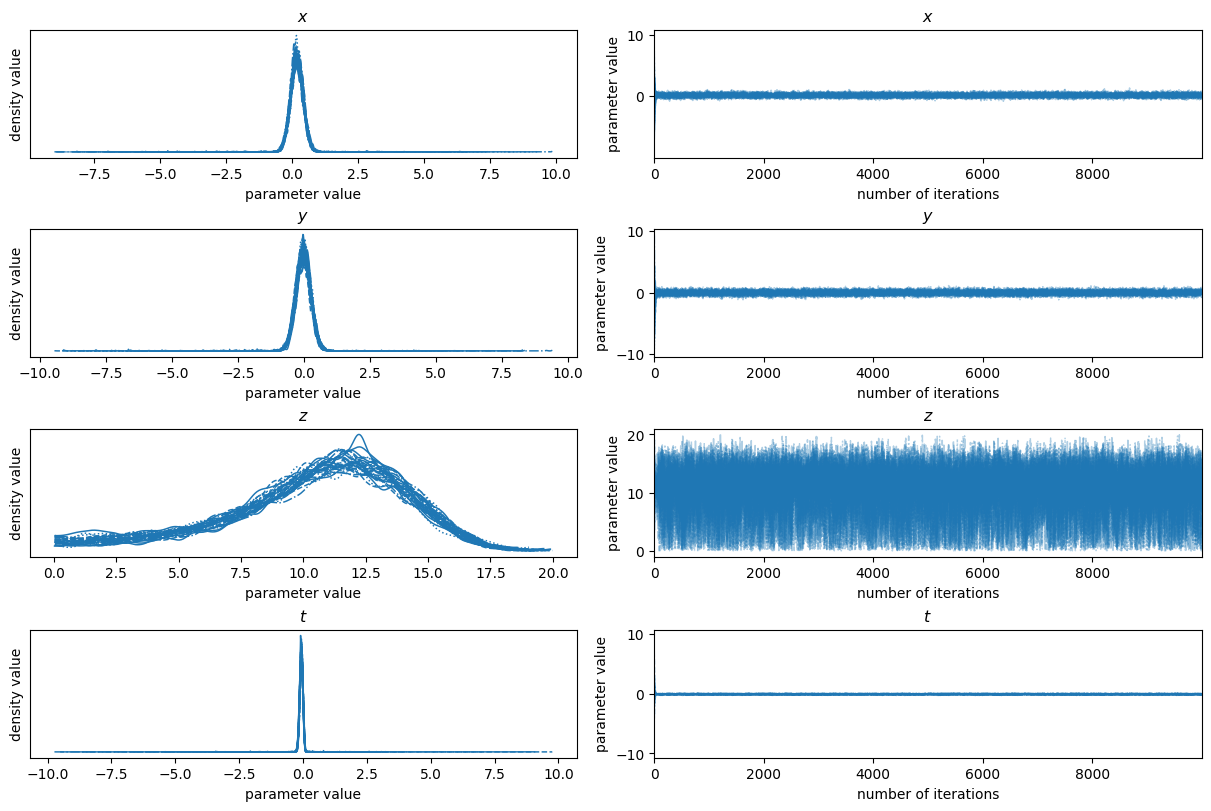

In [94]:
# a standard `trace` plot
axes = az.plot_trace(idata, backend_kwargs={"constrained_layout":True})
# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    # ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [95]:
tau = sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

autocorrelation time: [43.66177059 43.9063349  53.82244698 33.52725146]


In [96]:
flat_samples = sampler.get_chain(discard=600, thin=60, flat=True)

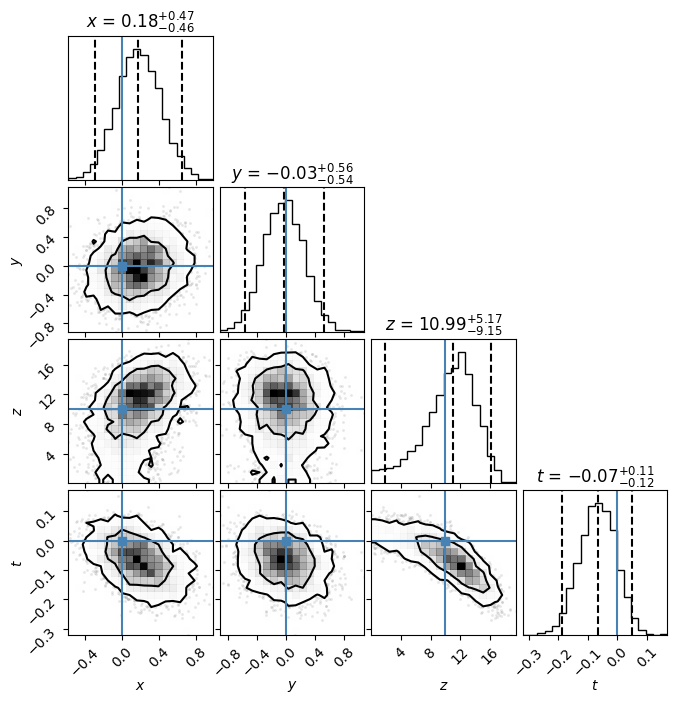

In [97]:
import corner
import matplotlib.pyplot as plt
fig = corner.corner(flat_samples, labels=labels, truths=m_true,
                     quantiles=[0.025, 0.5, 0.975], show_titles=True,
                     title_kwargs={"fontsize": 12},
                     levels=(0.68, 0.95), alpha=0.1)
fig.set_size_inches(7, 7)
plt.show()